In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [29]:
features = ['Month','Sales_volume','Total_sales','Unit_price','Unit_cost', 'ROI','Profit_rate', 'Time_to_peak']
target = 'Target'

class SalesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SalesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        lstm_out, hidden = self.lstm(x, hidden)
        predictions = self.fc(lstm_out)
        return predictions, hidden
    
class SalesStrategy():
    def __init__(self):
        """
        初始化SalesPredictor类，自动加载训练好的模型和scalers。

        参数:
        config_path: 配置文件路径，包含模型路径和超参数信息。
        """
        # 加载配置文件
        
        # 加载scalers
        self.feature_scaler = joblib.load('feature_scaler.pkl')
        self.target_scaler = joblib.load('target_scaler.pkl')

        # 初始化模型
        self.input_size = len(features)
        self.hidden_size = 50
        self.output_size = 1

        self.model = SalesLSTM(input_size=self.input_size, hidden_size=self.hidden_size, output_size=self.output_size)
        self.init_hidden =  (torch.zeros(1, 1, self.hidden_size),
                                 torch.zeros(1, 1, self.hidden_size))

        # 加载训练好的模型参数
        self.model.load_state_dict(torch.load('pillow_total_sales_model.pth'))
        self.model.eval()  # 设置为评估模式
    
    def predict_cycle(self, feature_params):
        """
        根据输入的特征数据预测下个月的销量

        参数:
        feature_params =  {
        'Estimated_sales':
        'Unit_price':
        'Unit_cost':
        'ROI':
        'Profit_rate':
        'Time_to_peak':
        }

        返回:
        预测的下个月销量
        """
        # 解析特征
        month = 1
        sales = 0
        total_sales = feature_params['Estimated_sales']
        unit_price = feature_params['Unit_price']
        unit_cost = feature_params['Unit_cost']
        roi = feature_params['ROI']
        profit_rate = feature_params['Profit_rate']
        time_to_peak = feature_params['Time_to_peak']
        
        # 将输入数据归一化
        input_features = [month, sales, total_sales, unit_price, unit_cost, roi, profit_rate, time_to_peak]
        month_idx = 0
        sales_idx = 1
        predictions= []
        hidden = self.init_hidden

        # 使用模型进行预测
        for i in range(12):
            with torch.no_grad():
                input_data_scaled = self.feature_scaler.transform(np.array(input_features).reshape(1, -1))
                # 将数据转换为PyTorch张量
                input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32).unsqueeze(0)  # 形状 (1, 1, input_size)

                y, hidden = self.model(input_tensor, hidden)
                print(y)
                prediction = self.target_scaler.inverse_transform(y.view(1,-1).numpy())[0][0]
                predictions.append(prediction)
                
                month += 1
                if month%12 == 0:
                    month = 1
                input_features[month_idx] = month
                input_features[sales_idx] = prediction
        
        return predictions

tensor([[[-0.5718]]])
tensor([[[-0.2254]]])
tensor([[[0.1522]]])
tensor([[[0.6836]]])
tensor([[[1.1845]]])
tensor([[[1.0410]]])
tensor([[[0.4503]]])
tensor([[[0.2064]]])
tensor([[[0.0695]]])
tensor([[[-0.2402]]])
tensor([[[-0.3935]]])
tensor([[[-0.6704]]])


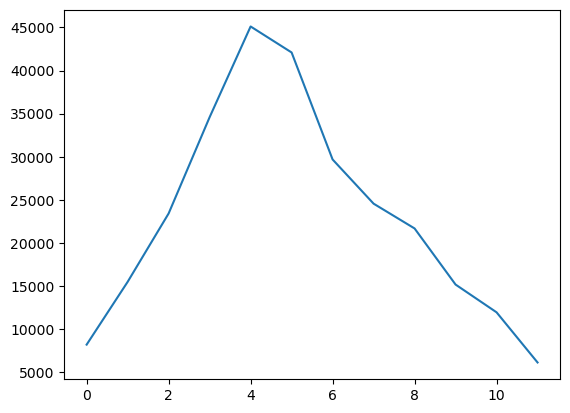

In [31]:
model = SalesStrategy()
feature_params =  {
        'Estimated_sales':600000,
        'Unit_price':102,
        'Unit_cost':50,
        'ROI':0.6,
        'Profit_rate':0.4,
        'Time_to_peak':4,
        }
predictions = model.predict_cycle(feature_params)
plt.plot(predictions)

In [24]:

a = torch.tensor([[[-0.5080]]])
a.view(1, -1).numpy().item()

-0.5080000162124634